In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks import *

In [3]:
torch.cuda.is_available()

True

In [4]:
np.random.seed(42)

In [5]:
tfms = get_transforms(do_flip=True,flip_vert=False,max_rotate=10.0,max_zoom=1.2,max_lighting=0.5,max_warp=0.2,p_affine=0.75,p_lighting=0.75)


In [6]:
mixup=0.2

In [7]:
loss_func = LabelSmoothingCrossEntropy()

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=1.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()
    
focal_loss_func = FocalLoss(gamma=2.)

In [9]:
alpha=0.99
mom=0.9
eps=1e-6

In [10]:
opt_func = partial(optim.Adam, betas=(mom,alpha), eps=eps)

In [11]:
src = (ImageList.from_folder(path='train').split_by_rand_pct(0.2).label_from_folder())

In [12]:
data = src.transform(tfms,size=(640)).databunch(bs=16).normalize()

In [13]:
learn = cnn_learner(data, models.densenet121,pretrained=False, metrics=[error_rate, accuracy, FBeta(beta=1,average='macro')],loss_func = loss_func,opt_func=opt_func,wd=1e-2)

/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [14]:
learn= learn.mixup(alpha=mixup)

In [15]:
learn.bn_wd=False

In [16]:
learn.true_wd=True

In [17]:
learn.load('exp-11-round-1')

Learner(data=ImageDataBunch;

Train: LabelList (65934 items)
x: ImageList
Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640)
y: CategoryList
class-540,class-526,class-771,class-4,class-804
Path: train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [18]:
src_new = (ImageList.from_folder(path='train',include=["class-390","class-653","class-140","class-67"]).split_by_rand_pct(0.2).label_from_folder())

In [19]:
data_new = src_new.transform(tfms,size=(896)).databunch(bs=12).normalize()

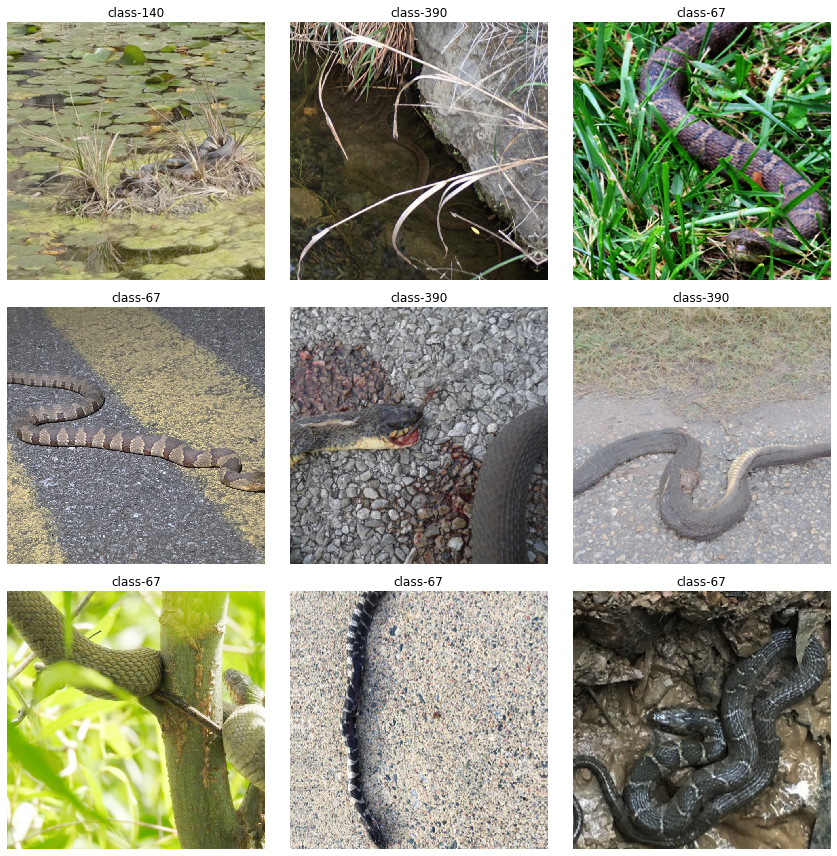

In [20]:
data_new.show_batch(rows=3, figsize=(12,12))

In [21]:
learn.data = data_new

In [22]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 448, 448]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 448, 448]       128        True      
______________________________________________________________________
ReLU                 [64, 448, 448]       0          False     
______________________________________________________________________
MaxPool2d            [64, 224, 224]       0          False     
______________________________________________________________________
BatchNorm2d          [64, 224, 224]       128        True      
______________________________________________________________________
ReLU                 [64, 224, 224]       0          False     
______________________________________________________________________
Conv2d               [128, 224, 224]      8,192      True      
___________________________________________________

In [23]:
concat_pool=True

In [24]:
nf = num_features_model(nn.Sequential(*learn.model[0].children())) * (2 if concat_pool else 1)

In [25]:
nf

2048

In [26]:
custom_head=create_head(nf, 4, None, ps=0.5, concat_pool=concat_pool, bn_final=False)

In [27]:
learn.model = nn.Sequential(*list(children(learn.model))[:-1], custom_head)

In [28]:
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_ru

In [29]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 448, 448]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 448, 448]       128        True      
______________________________________________________________________
ReLU                 [64, 448, 448]       0          False     
______________________________________________________________________
MaxPool2d            [64, 224, 224]       0          False     
______________________________________________________________________
BatchNorm2d          [64, 224, 224]       128        True      
______________________________________________________________________
ReLU                 [64, 224, 224]       0          False     
______________________________________________________________________
Conv2d               [128, 224, 224]      8,192      True      
___________________________________________________

In [30]:
learn = learn.to_fp16(dynamic=True)

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


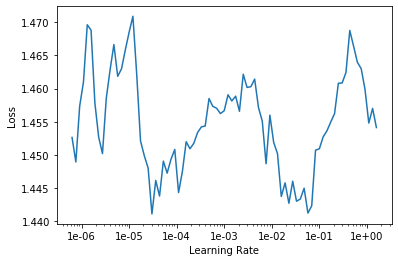

In [32]:
learn.recorder.plot()

In [33]:
lr=5e-4

In [34]:
learn.fit_one_cycle(40,lr,div_factor=10,pct_start=0.3)

epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,1.410332,1.321893,0.621832,0.378168,0.356228,04:24
1,1.406966,1.284321,0.561404,0.438596,0.408988,04:20
2,1.371394,1.231111,0.482131,0.517869,0.474342,04:16
3,1.341288,1.164228,0.417154,0.582846,0.532830,04:14
4,1.269980,1.110106,0.372320,0.627680,0.581539,04:15
5,1.253482,1.069015,0.361274,0.638726,0.593401,04:16
6,1.221696,1.008826,0.312541,0.687459,0.644542,04:16
7,1.175717,0.978163,0.296296,0.703704,0.657164,04:16
8,1.179122,0.925127,0.267706,0.732294,0.692538,04:14
9,1.153181,0.925122,0.281352,0.718648,0.676524,04:12


In [35]:
learn.save('nerodia-round-1')

In [36]:
interp = ClassificationInterpretation.from_learner(learn)


In [37]:
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

False

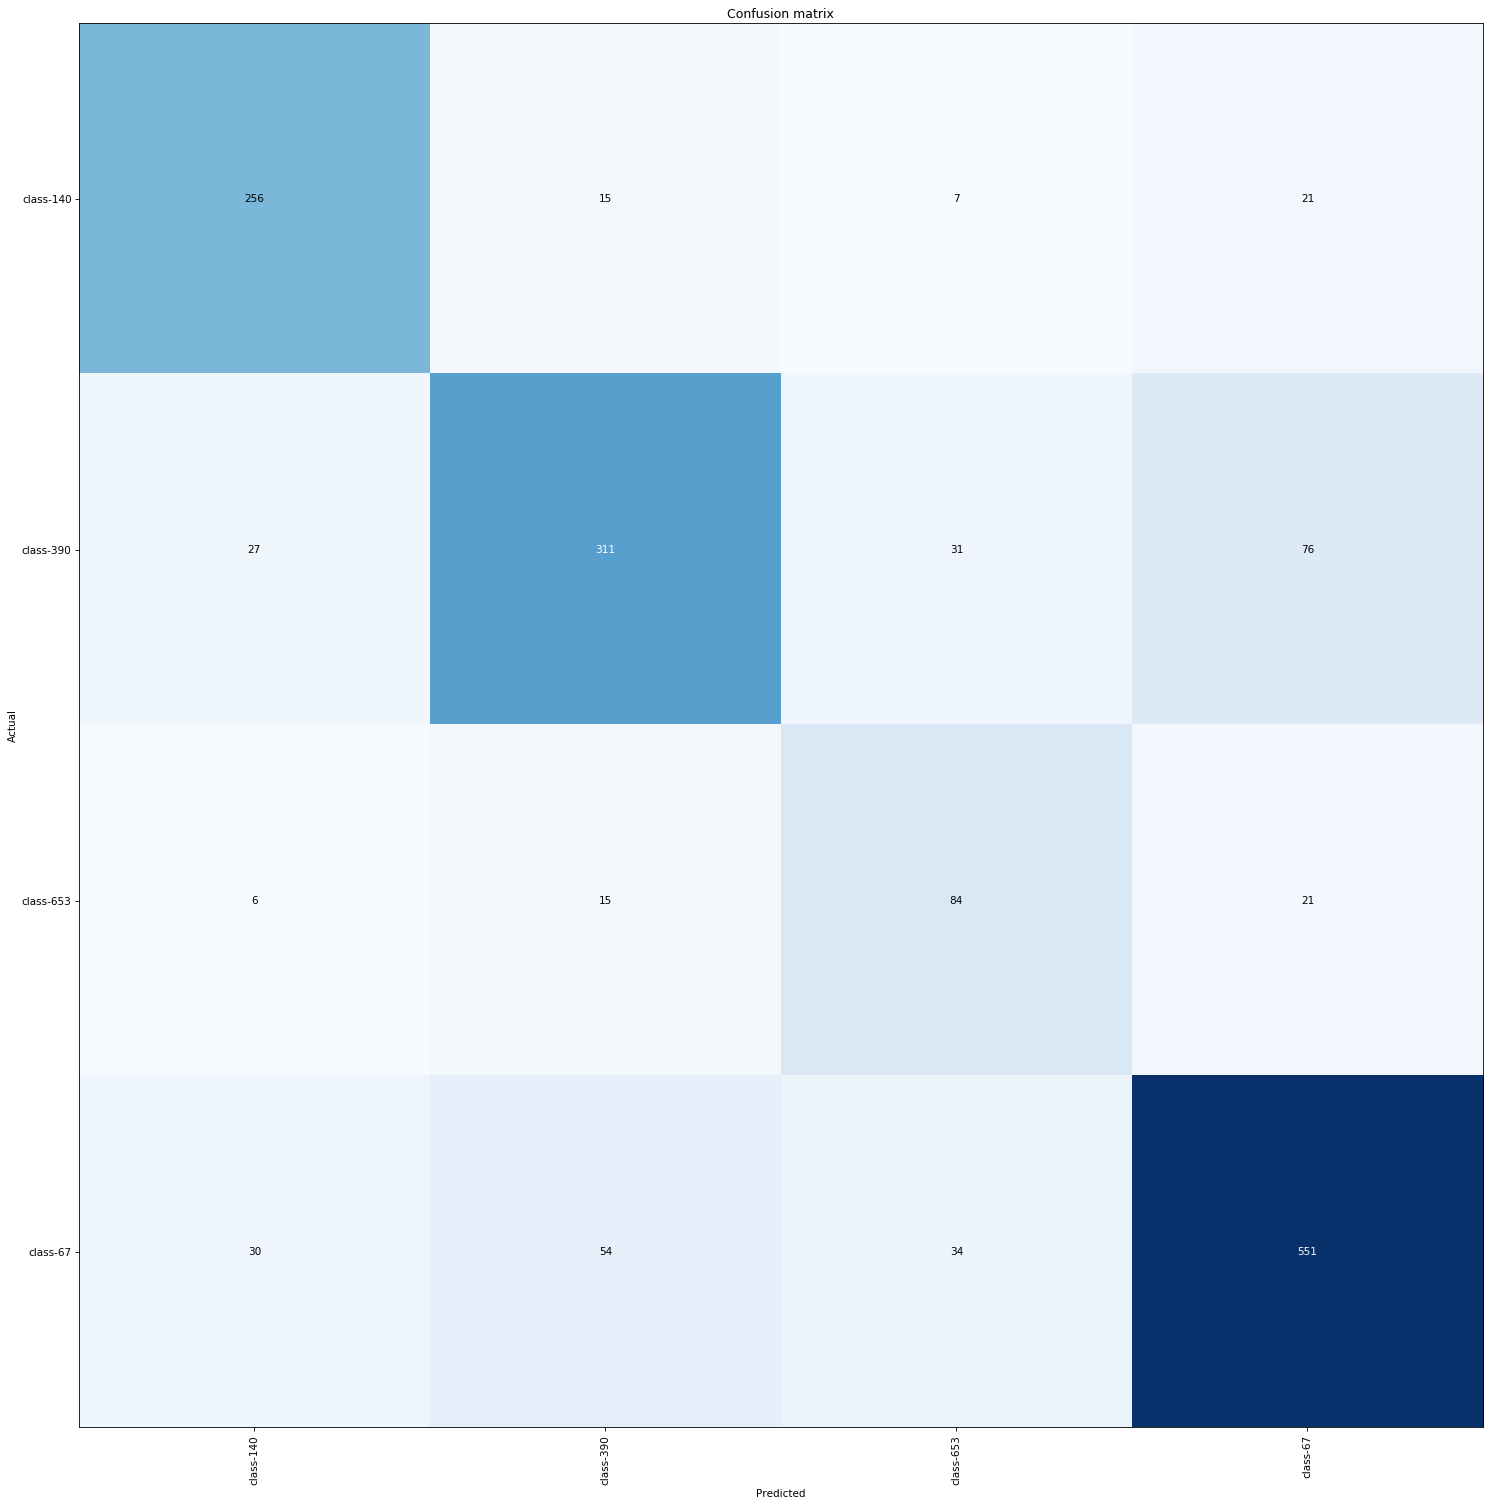

In [38]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=75)


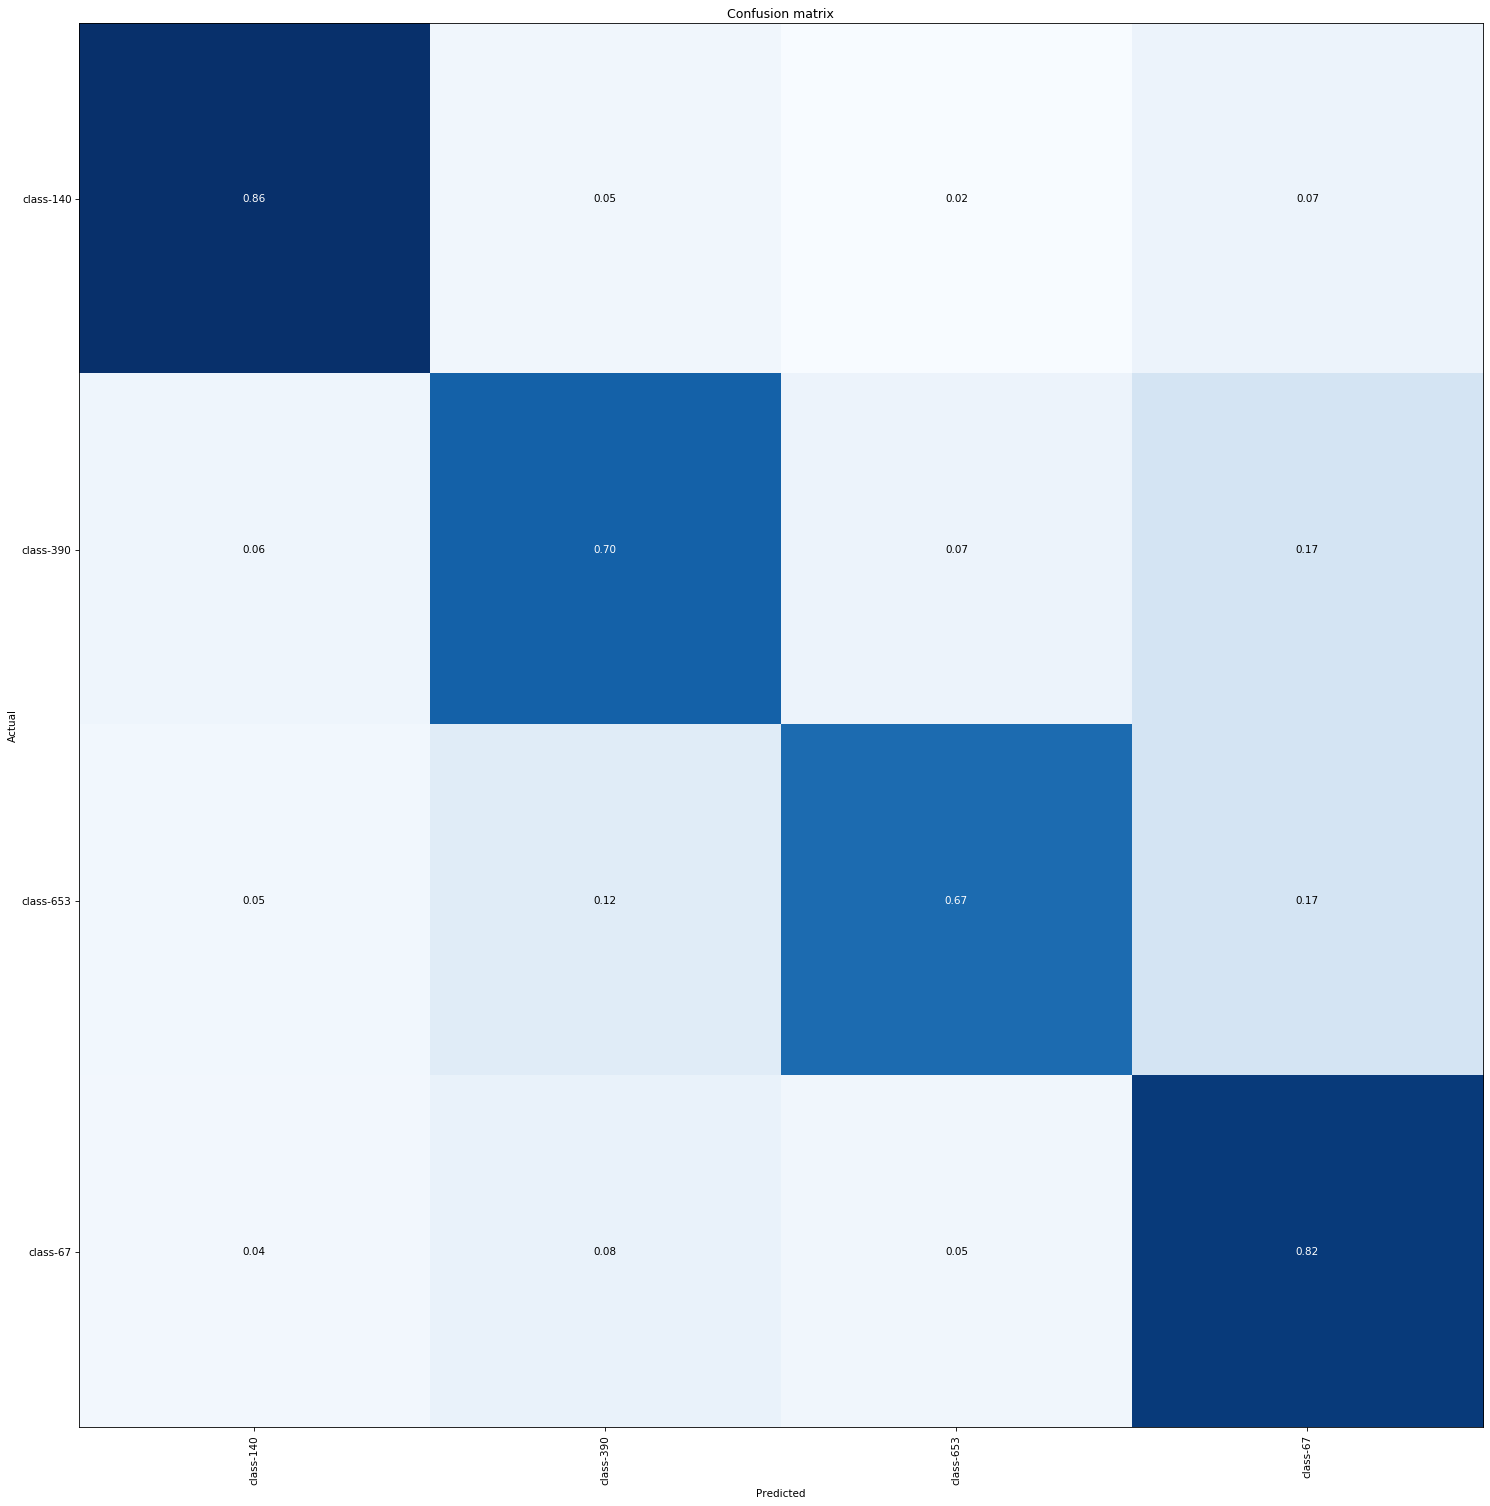

In [39]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=75,normalize=True)


In [40]:
interp.most_confused(min_val=2)


[('class-390', 'class-67', 76),
 ('class-67', 'class-390', 54),
 ('class-67', 'class-653', 34),
 ('class-390', 'class-653', 31),
 ('class-67', 'class-140', 30),
 ('class-390', 'class-140', 27),
 ('class-140', 'class-67', 21),
 ('class-653', 'class-67', 21),
 ('class-140', 'class-390', 15),
 ('class-653', 'class-390', 15),
 ('class-140', 'class-653', 7),
 ('class-653', 'class-140', 6)]

In [41]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


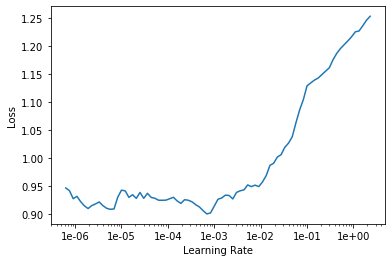

In [42]:
learn.recorder.plot()

In [43]:
lr=1e-5

In [44]:
learn.fit_one_cycle(10,lr,div_factor=10,pct_start=0.3)

epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,0.926311,0.783073,0.207927,0.792073,0.757074,04:13
1,0.925955,0.769844,0.204678,0.795322,0.761324,04:12
2,0.906553,0.796822,0.213125,0.786875,0.757023,04:13
3,0.912221,0.777023,0.205978,0.794022,0.765023,04:11
4,0.917538,0.785248,0.215724,0.784276,0.749191,04:11
5,0.916988,0.788405,0.204678,0.795322,0.764894,04:10
6,0.938120,0.771876,0.207927,0.792073,0.758153,04:11
7,0.884470,0.780511,0.211826,0.788174,0.751163,04:10
8,0.906627,0.776121,0.204029,0.795971,0.762359,04:11
9,0.913343,0.784252,0.209227,0.790773,0.754530,04:11


In [45]:
learn.save('nerodia-round-2')

In [53]:
interp = ClassificationInterpretation.from_learner(learn)


TypeError: __init__() got multiple values for argument 'reduction'

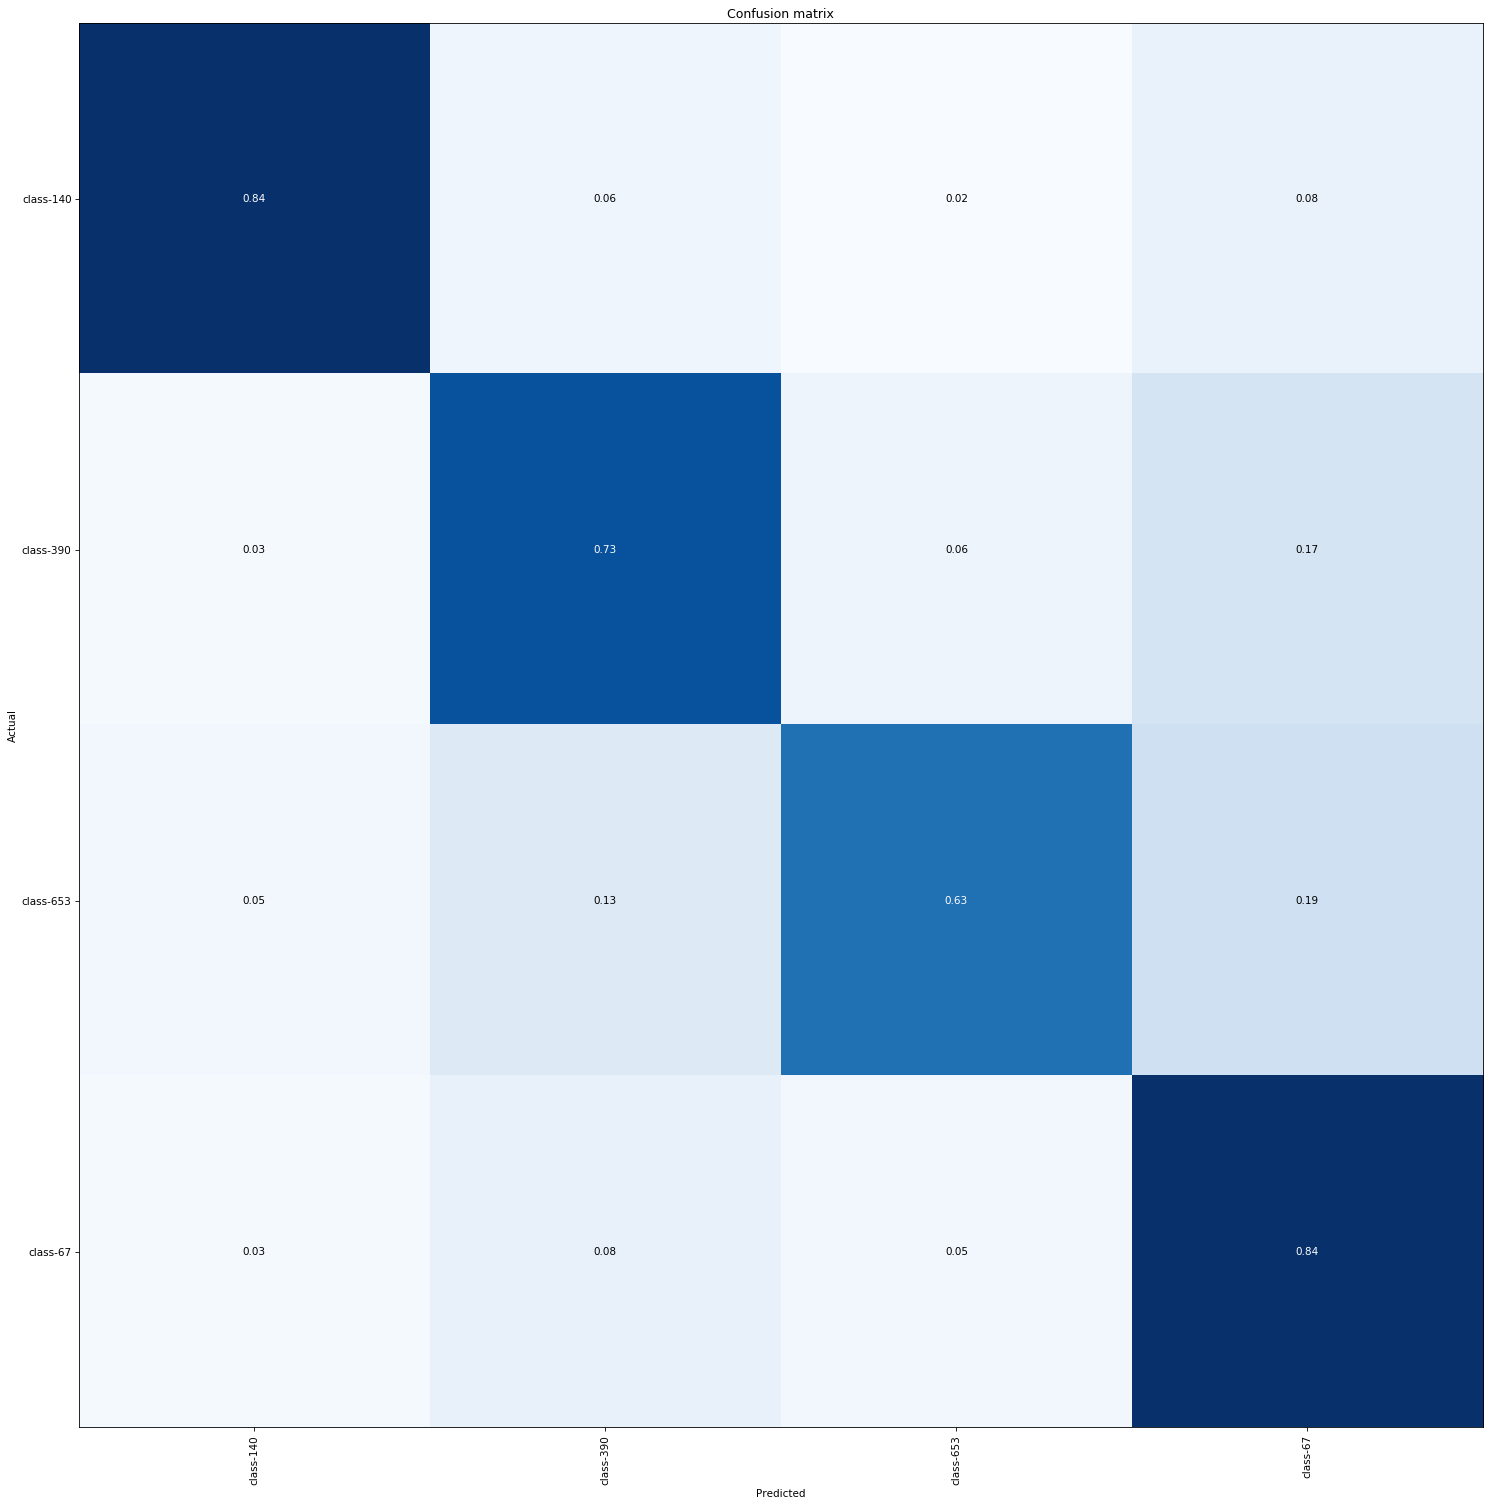

In [49]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=75,normalize=True)


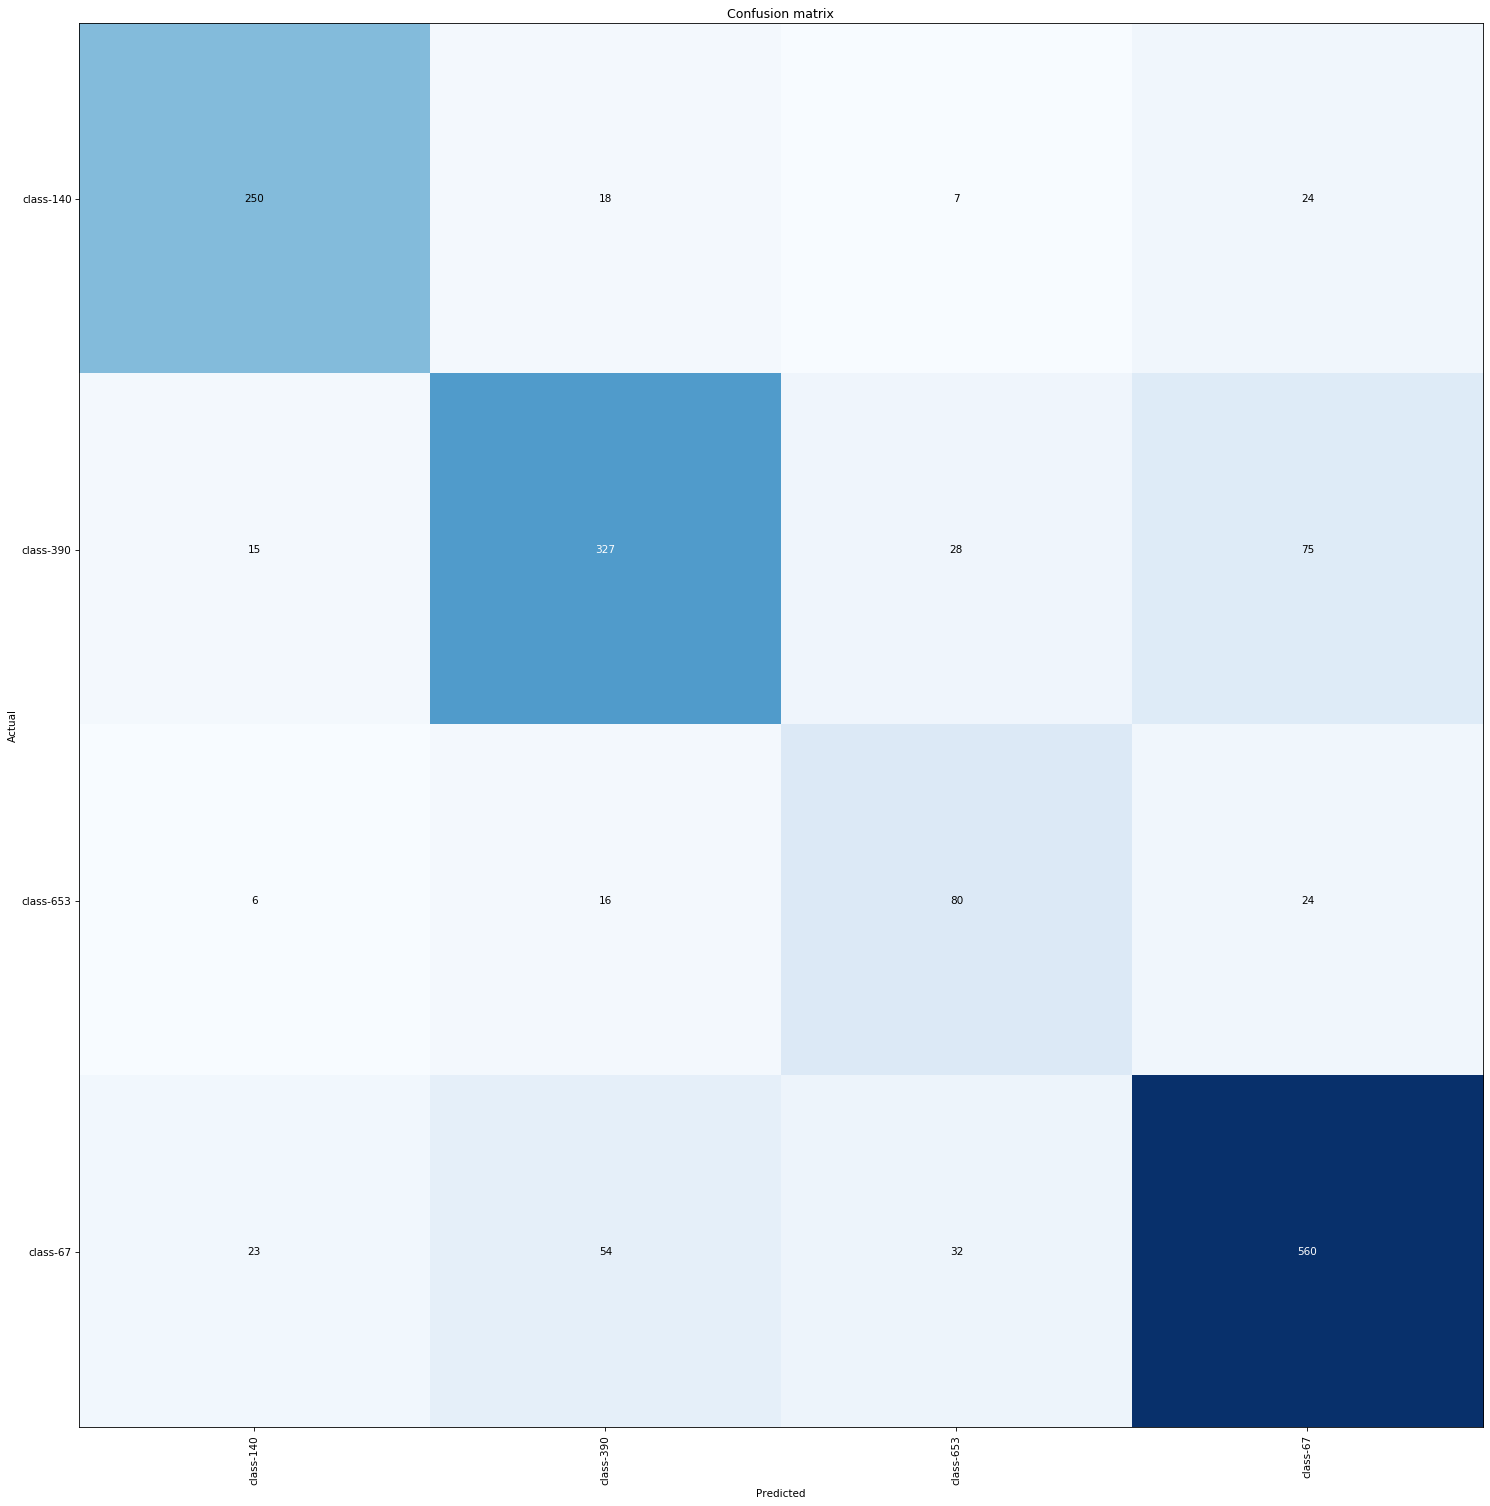

In [50]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=75,normalize=False)

In [52]:
learn.loss_func = LabelSmoothingCrossEntropy

In [54]:
interp.plot_top_losses(6, figsize=(30,22))

TypeError: len() of a 0-d tensor